<a href="https://colab.research.google.com/github/AndreisMarco/02456_G128_bird_classification/blob/main/scripts/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started
This is a minimal example to show you how to load models and data and extract hidden representations of your data.


## Prep for Colab (edit by Csilla)
- install datasets
- mount Drive
- connect to your folder in Drive
- create output folder
- import metrics files from py files

In [5]:
!pip install datasets pynndescent --quiet

In [24]:
# for folder handling
from google.colab import drive
import os

# import python files from folder: convexity and similarity_metrics
from convexity import graph_convexity
from similarity_metrics import cka, mutual_knn, cosine_similarity

In [6]:
# mount Drive and set path
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deep Learning - DTU 2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create outputs folder (if not existent)
os.mkdir('outputs')

## Example with models and data from huggingface

You can find many models and datasets on [huggingface.co](https://huggingface.co/), check out https://superbbenchmark.github.io/ for some inspiration for tasks and models.

You can of course also choose any other model and task you want to work with (within audio), but I would strongly recommend to use a transformer based model.

In [17]:
# load model and data from huggingface
import os
import sys
import numpy as np
import torch
from datasets import load_dataset
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

# load pretrained model (here wav2vec2)
# you can find many other models on huggingface.co
processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# load data
# you can find many other datasets on huggingface.co
dataset = load_dataset("speech_commands", "v0.02")

#prepapre an example dataset
data = dataset["test"]
data = data.filter(lambda example: example["label"] in range(11)) # lets only keep 10 classes
data = data.shuffle(seed=42)
data = data.select(range(500))
# save labels for later analysis
np.save("outputs/labels.npy", data["label"])


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**How to extract representations**

In [18]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu" # you should use a GPU for this task, otherwise it will be very slow

def extract_features(model, processor, dataset, output_dir, num_layers=13, num_features=768):
    model.to(device)

    #initialize hidden states tensor to avoid itereative concatenation which is very slow
    hidden_states = torch.zeros((len(dataset), num_layers, num_features))

    # iterate over the dataset
    for i, example in enumerate(tqdm(dataset)):
        #preprocess the data, check your data how to call your audio file (here it is ["audio"]["array"])
        inputs = processor(example["audio"]["array"], return_tensors="pt", padding='max_length', max_length=16000, sampling_rate=16000).input_values.to(device)

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # average the hidden states over the time axis for each layer j
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        #optional saving after 100 steps
        # depending on the size of your dataset this process can time out so better save intermediate results
        if i>0 and i%100 == 0:
            np.save(os.path.join(output_dir, f"hidden_states.npy"), hidden_states.cpu().numpy())

    np.save(os.path.join(output_dir, f"hidden_states.npy"), hidden_states.cpu().numpy())


# run a small experiment with 100 random samples

extract_features(model, processor, data, "outputs")


100%|██████████| 500/500 [03:48<00:00,  2.19it/s]


## Visualizing the hidden representations

Here we use TSNE, you can also use PCA, UMAP or PHATE or any other method you like.
This is useful to give a first intuition on whats happening inside our model.

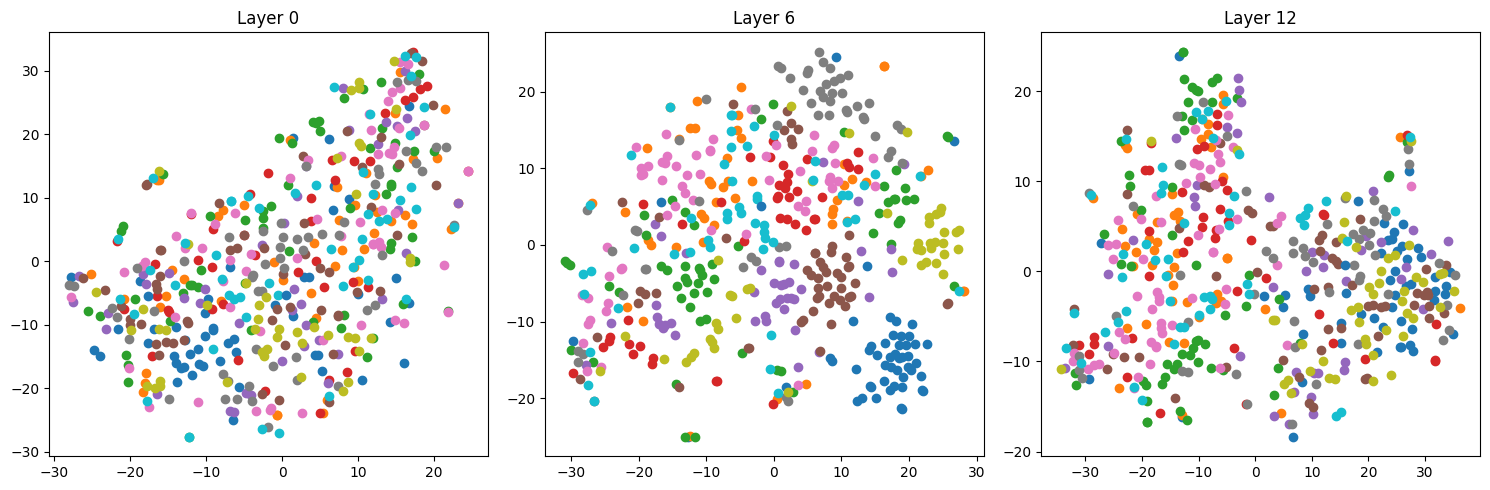

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# lets load the hidden states and check the shape
hidden_states = np.load("outputs/hidden_states.npy")
labels = np.load("outputs/labels.npy")
unique_labels = np.unique(labels)

# visualize the hidden states using tsne of a few layers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, layer in enumerate([0, 6, 12]):
    X_embedded = TSNE().fit_transform(hidden_states[:, layer, :])
    ax = axes[idx]
    for i in range(len(unique_labels)):
        ax.scatter(X_embedded[labels == unique_labels[i], 0], X_embedded[labels == unique_labels[i], 1], marker='o')
    ax.set_title(f"Layer {layer}")

plt.tight_layout()
plt.show()



## Run a similarity analysis across layers

Here we use three common methods: CKA, cosine similarity and mutual kNN

These papers are good to check out for similarity analysis:


Kornblith, S., Norouzi, M., Lee, H. &amp; Hinton, G.. (2019). Similarity of Neural Network Representations Revisited. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:3519-3529 Available from https://proceedings.mlr.press/v97/kornblith19a.html.

Huh, M., Cheung, B., Wang, T., & Isola, P. (2024). The platonic representation hypothesis. arXiv preprint arXiv:2405.07987. https://arxiv.org/abs/2405.07987  *(this one is generally intresting to read but not necessary for this project)*



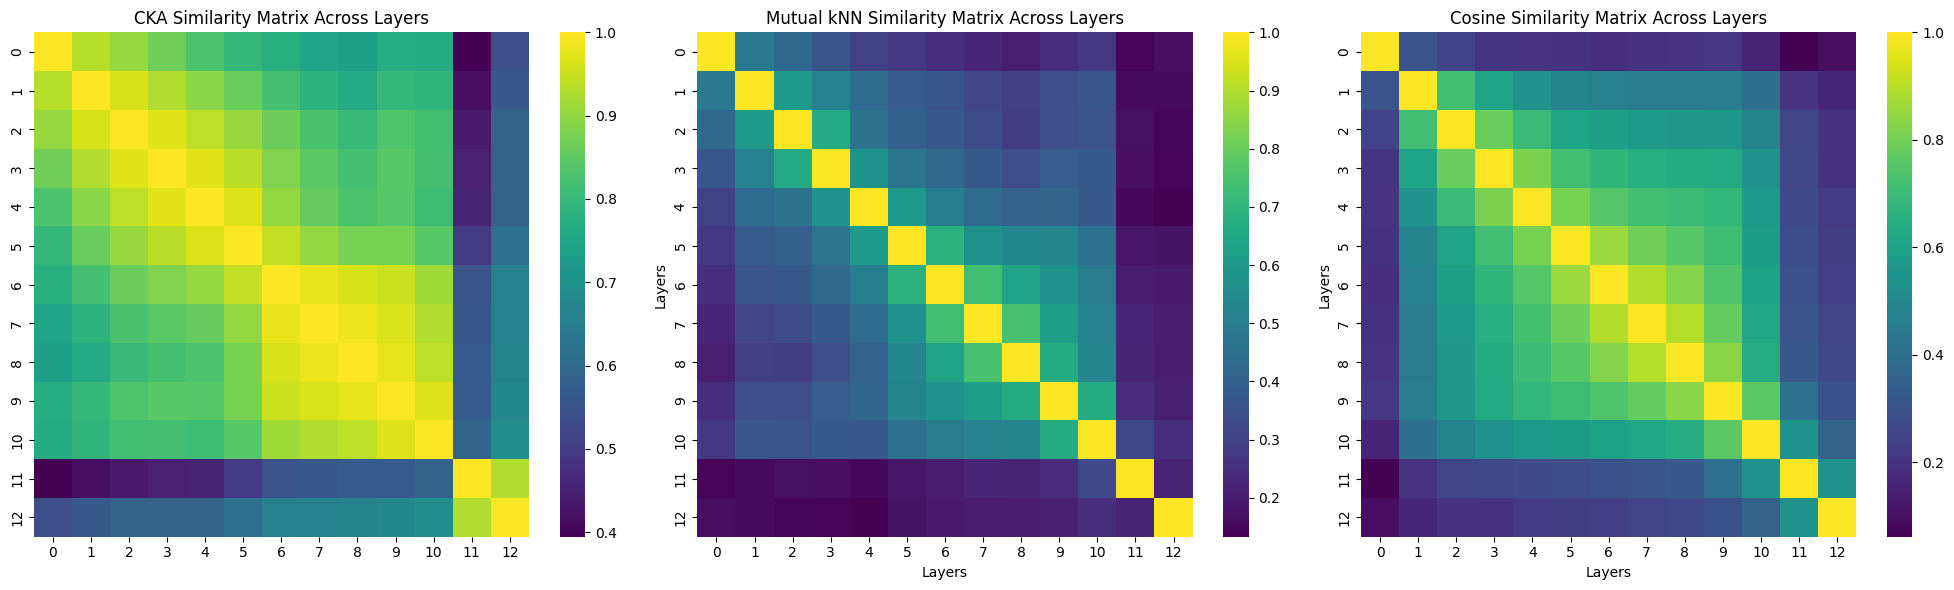

In [22]:
import seaborn as sns
# from src.similarity_metrics import cka, mutual_knn, cosine_similarity -- imported above
import matplotlib.pyplot as plt

# hidden_states = np.load("hidden_states/hidden_states.npy") -- changed to outputs folder
hidden_states = np.load("outputs/hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

## Convexity analysis

This is based on my prior work and you do not have to do this in your project. But it can give a nice intuition of where your model forms convex regions of the classes you are intrested in and which layers "know" the most about your task.

Check out these papers:

Dorszewski, T., Tětková, L., & Hansen, L. K. (2024). Convexity-based Pruning of Speech Representation Models. arXiv preprint arXiv:2408.11858. https://arxiv.org/pdf/2408.11858 *(Recommended to read)*

Tetková, L., Brüsch, T., Scheidt, T. K., Mager, F. M., Aagaard, R. Ø., Foldager, J., ... & Hansen, L. K. (2023). On convex conceptual regions in deep network representations. https://arxiv.org/pdf/2305.17154 *(Introduction of convexity score, additional read if you want to know more)*


Start Layer 0
Layer 0:  (0.30805474413069356, 0.28122255911022637)
Start Layer 1
Layer 1:  (0.39424429297847013, 0.29919049242648116)
Start Layer 2
Layer 2:  (0.46736178729849615, 0.31337076314950396)
Start Layer 3
Layer 3:  (0.454817158931083, 0.31767220638805244)
Start Layer 4
Layer 4:  (0.5379259980525803, 0.3211075497358875)
Start Layer 5
Layer 5:  (0.6650505788164016, 0.3066651277209741)
Start Layer 6
Layer 6:  (0.7285716217678242, 0.2881536210001323)
Start Layer 7
Layer 7:  (0.7800646435140106, 0.2654959190610882)
Start Layer 8
Layer 8:  (0.7789759818240831, 0.26824674967224554)
Start Layer 9
Layer 9:  (0.611614194525587, 0.3117897359147335)
Start Layer 10
Layer 10:  (0.5066766742399653, 0.31749205630602406)
Start Layer 11
Layer 11:  (0.36213215406253374, 0.2913527612270997)
Start Layer 12
Layer 12:  (0.3895434382776155, 0.2943230180994499)


Text(0.5, 1.0, 'Convexity of Words Across Layers')

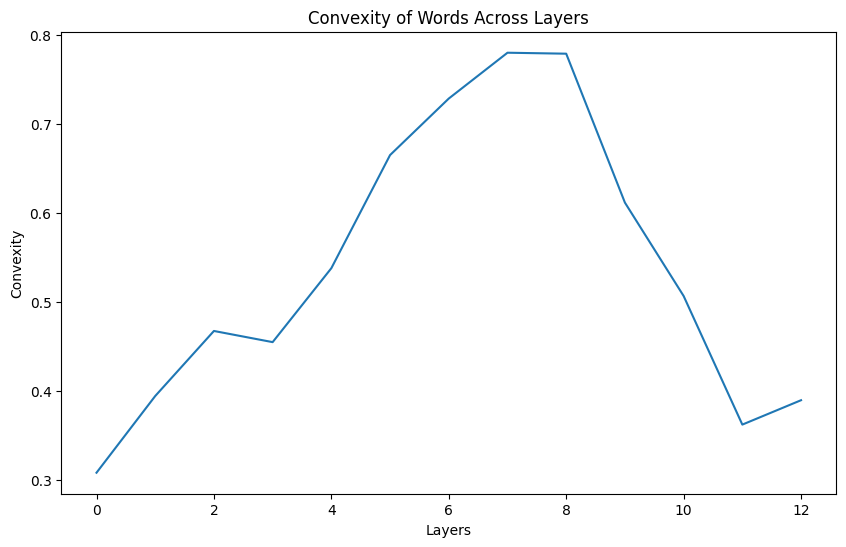

In [25]:
# from src.convexity import graph_convexity -- imported above

hidden_states = np.load("outputs/hidden_states.npy")
labels = np.load("outputs/labels.npy")

# Compute convexity, this can take some time depending on the size of the dataset
convexity,_ = graph_convexity(hidden_states, labels, num_neighbours=10)

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in convexity])
plt.xlabel("Layers")
plt.ylabel("Convexity")
plt.title("Convexity of Words Across Layers")

As you will see if everything worked out, the 10 different words (classes) form convex regions especially in middle layers, eventhough the model was never specifically trained to distinguish words.
You can check out my paper from above to see how this changes when you finetune a model.


## Pruning

I will update this soon and have some examples of pruning. For now you should focus on training a model and understanding the representations.

Here are some papers you can check out for now if you are really eager:

Dorszewski, T., Jacobsen, A. K., Tětková, L., & Hansen, L. K. (2024). How Redundant Is the Transformer Stack in Speech Representation Models?. arXiv preprint arXiv:2409.16302. https://arxiv.org/pdf/2409.16302 *(result from a student project this year, recommended to read)*

Y. Peng, K. Kim, F. Wu, P. Sridhar and S. Watanabe, "Structured Pruning of Self-Supervised Pre-Trained Models for Speech Recognition and Understanding," ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), https://ieeexplore.ieee.org/abstract/document/10095780

